<h1> Guiding Jupyter Notebook to Paper </h1>

Notebook to show some key results and providing an introduction to the code used. A pre-set GANs is loaded to show some results if the Feller condition is strongly violated, where we let $\delta = 0.11$, which is well below 2. 

In [21]:
import os,sys
import os.path as pt
import numpy as np
import torch 
import matplotlib.pyplot as plt
import scipy.stats as stat
import statsmodels.distributions as smd


from nets import Generator, Discriminator, load_Generator, load_Discriminator
from paths import make_GAN_paths
from utils import unpickle, input_sample, dict_to_tensor, make_test_tensor,\
preprocess
from CGANalysis import CGANalysis
from sde_dataset import SDEDataset
from presets import load_preset
from data_types import Preset, Activation, PreProcessing

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
#---------------------------------
# Set up some global parameters 
#---------------------------------

torch.manual_seed(0)
np.random.seed(0)

path = os.getcwd()
# Process the data by scaling with a reference value 
proc_type = PreProcessing.SCALE_S_REF

# Use the cpu for this example 
device = 'cpu'

<h2> Dataset with Feller condition violated, $\delta = 0.11$ </h2>

Stored 10000 exact CGAN CIR samples using params {'t': array([0.4, 0.2, 1. , ..., 0.4, 0.4, 0.2]), 'S0': array([5.33669923e-04, 1.00000000e+00, 8.11130831e-02, ...,
       4.32876128e-05, 1.87381742e-03, 8.11130831e-02]), 'S0_test': 1, 'mu': 0.05, 'sigma': 0.2, 'kappa': 0.1, 'S_bar': 0.1, 'gamma': 0.6, 's': 0} in [instance_name].exact
Stored 10000 exact CGAN test samples using params {**self.params, **self.C_test}in [instance_name].exact_test
Stored 10000 normal samples Z in [instance_name].Z and [instance_name].Z_test


Text(0.5, 1.0, 'CDF of data')

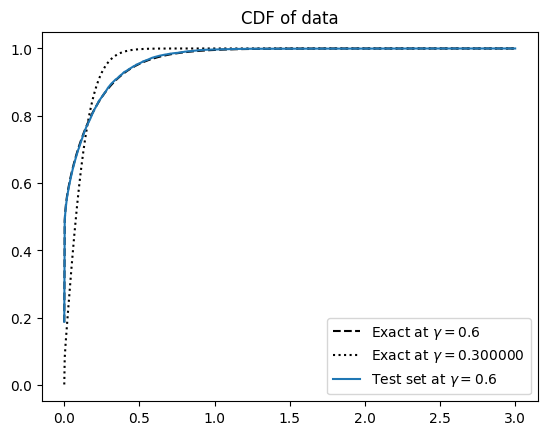

In [12]:
X = load_preset(Preset.CIR_FELLER_VIOLATED_HIGH_GAMMA)

x = np.linspace(1e-10,3,1000)
plt.figure(dpi=100)
plt.plot(x, X.exact_cdf_CIR(params=X.params.update(X.C_test))(x), '--k',label='Exact at $\gamma=${0:1.1f}'.format(X.params['gamma']))

# Changing gamma to 0.6, but keeping the rest of the parameters fixed 
plt.plot(x, X.exact_cdf_CIR(params={**X.params, **X.C_test, **dict(gamma=0.3)})(x), ':k',label='Exact at $\gamma=${0:1f}'.format(0.3))

# Y = X.get_exact_CIR_samples(X.params.update(X.C_test)).view(-1).numpy()
Y = X.exact_test.view(-1).numpy()
ECDF = smd.ECDF(Y)
plt.plot(x, ECDF(x), '-', label='Test set at $\gamma={0:1.1f}$'.format(X.params['gamma']))

plt.legend()
plt.title('CDF of data')


We can very easily add plots by changing the model parameters and updating the dict. Note the strong non-singular behaviour near the origin and the heavy right-tail. This case is the most challenging. 

<h2> Studying the output distribution </h2>
Let us tackle this challenging case of $\gamma=0.6$ with the supervised GAN. The generator used here is already pre-trained. First we study the distribution of the output. 

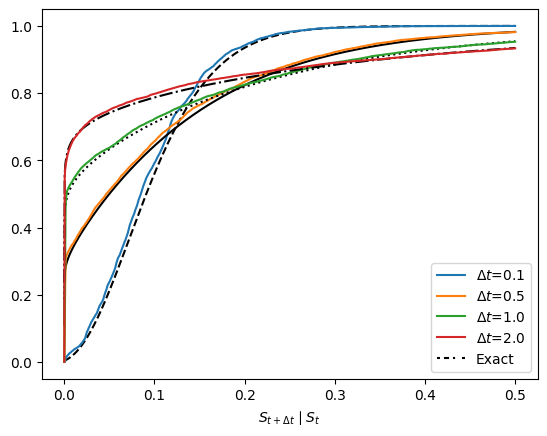

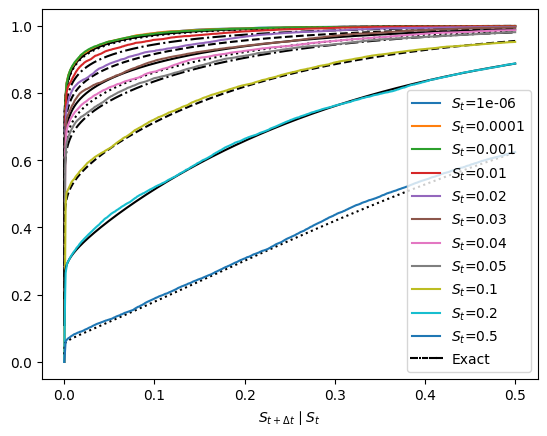

In [23]:
# Paths to the generator and discriminator in pre-trained nets folder 
# generator_path = pt.join(path,'pre_trained_nets','high_gamma','supervised','netG.pth')
# discriminator_path = pt.join(path,'pre_trained_nets','high_gamma','supervised','netD.pth')


generator_path = pt.join(path,'output','iter_1','netG.pth')
discriminator_path = pt.join(path,'output','iter_1','netD.pth')

# Two conditional variables as input to the generator: $S_t$ and $\Delta t$. Note that the order matters (!)
c_dim = 2

# Load the generator from the pre-trained models 
netG = load_Generator(generator_path, c_dim=c_dim, hidden_dim=200,\
                      activation=Activation.LEAKY_RELU, negative_slope=0.1, output_activation=None, device=device)
# Add 1 to c_dim for the parameter Z
netD = load_Discriminator(discriminator_path,c_dim=c_dim+1,hidden_dim=200,\
                      activation=Activation.LEAKY_RELU, output_activation=Activation.SIGMOID, device=device)


analysis = CGANalysis(X,netD,netG,SDE=X.SDE,proc_type=proc_type,device=device)

x = np.linspace(1e-10,0.5,1000)

C_plot = dict(t=[0.1,0.5,1,2])
analysis.ecdf_plot(C=C_plot,params=X.params,save=False,x_plot=x,legendname='$\Delta t$')
C_plot = dict(S0=[1e-6,1e-4,1e-3,1e-2,2e-2,3e-2,4e-2,5e-2,0.1,0.2,0.5])
analysis.ecdf_plot(C=C_plot,params=X.params,save=False,x_plot=x,legendname='$S_t$')


$\Rightarrow$ The GAN is clearly able to capture the conditional distribution even for this highly challenging distribution. 

<h2> Paths obtained with the GAN </h2>

Let us sample <b> 10,000 paths </b> with the supervised GAN and this time also load the vanilla GAN. We <b> stress-test </b> the GANs by repeating it <b> 100 time steps </b> on itself, i.e. very large time horizons at large time steps. 

In [27]:
# vanilla_generator_path = pt.join(path,'pre_trained_nets','high_gamma','vanilla','netG.pth')
vanilla_generator_path = pt.join(path,'output','iter_0','netG.pth')

netG_vanilla = load_Generator(vanilla_generator_path,c_dim=c_dim,activation=Activation.LEAKY_RELU,\
                              hidden_dim=200,negative_slope=0.1,device=device)

torch.manual_seed(0)
np.random.seed(seed=0)

# Set up metaparameters for experiment 
n_step = 100
n_path = 10_000
dt = 1
eps = 1e-20

# Create 10,000 vectors of random increments defining the paths 
# these will serve as input to all models 
inc = torch.randn((n_path,n_step))

# Set the conditional parameters for the paths 
X.C_test['t'] = dt
X.params['t'] = dt
X.params['S0'] = 0.1



steps_vec = np.arange(0,n_step+1)

times = dt*steps_vec

#---------------------------
# Make paths 
#---------------------------

Z_paths = torch.zeros((n_path,n_step))
paths_Exact = np.zeros((n_path,n_step+1))
paths_Exact[:,0] = X.params['S0']

# First construct the reference samples 
for i in range(n_step):
    paths_Exact[:,i+1] = X.get_exact_CIR_samples(N=n_path,params={**X.params,**dict(S0=paths_Exact[:,i],t=dt)}).view(-1).numpy()+eps
    # Draw samples Z
    cdf_s_t = X.exact_cdf_CIR(params={**X.params,**dict(S0=paths_Exact[:,i],t=dt)})
    Z_paths[:,i] = torch.tensor(stat.norm.ppf(cdf_s_t(paths_Exact[:,i+1])),dtype=torch.float32)
    
# Create paths with each GAN, using the method 'make_GAN_paths'
paths_GAN = make_GAN_paths(X,netG,n_step,C=dict(S0=X.params['S0']*np.ones(n_path),t=dt),Z=Z_paths,\
                           N_paths=n_path,proc_type=proc_type,device=device).cpu().numpy()
paths_vanilla_GAN = make_GAN_paths(X,netG_vanilla,n_step,C=dict(S0=X.params['S0']*np.ones(n_path),t=dt),Z=Z_paths,\
                                   N_paths=n_path,proc_type=proc_type,device=device).cpu().numpy()


# Make paths with the truncated Euler scheme and Milstein scheme by ()
paths_Eul = X.make_CIR_trunc_Euler_paths(n_steps=n_step,dt=dt,N_paths=n_path,Z=Z_paths,params=X.params).numpy()
paths_Mil = X.make_CIR_Milstein_paths_paper(n_steps=n_step,dt=dt,N_paths=n_path,Z=Z_paths,params=X.params).numpy()



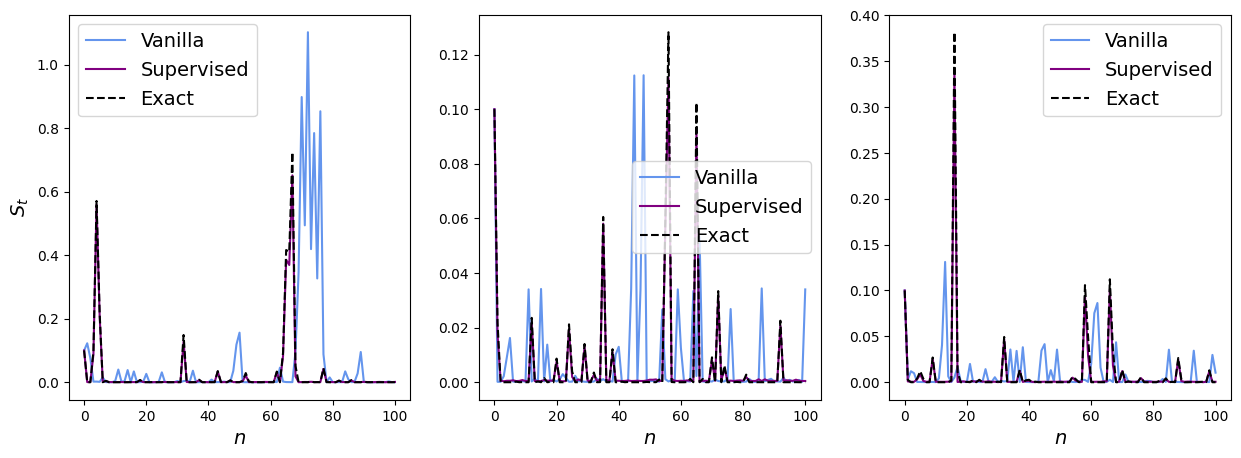

In [28]:
#---------------------------
# Plot some paths 
#---------------------------

fs = 14
plt.figure(dpi=100,figsize=(15,5))

for index in np.arange(1,4):
    plt.subplot(1,3,index)
    plt.plot(paths_vanilla_GAN[index,:],'-',label='Vanilla',color='cornflowerblue')
    plt.plot(steps_vec,paths_GAN[index,:],label='Supervised',color='purple')
    plt.plot(steps_vec,paths_Exact[index,:],label='Exact',linestyle='--',color='black')
    # plt.plot(paths_Mil[index,:],'--',label='Milstein',color='green')
    plt.xlabel('$n$',fontsize=fs)
    if index == 1:
        plt.ylabel('$S_t$',fontsize=fs)
    plt.legend(fontsize=fs)

$\Rightarrow$ We see the exteme tail of the distribution reflected in the sudden 'spikes', and the near-singular behaviour in the tendency to get very close to zero. The combination of these makes this distribution very challenging. The supervised GAN manages to approximate the process path-wise, even after up to 100 repetitions. 

<h2> Map obtained with both GANs </h2>

No condition dict given, providing dataset for vanilla GAN...
Stored 100 exact ncx2 samples using params using params {'t': 1, 'S0': 0.1, 'S0_test': 1, 'mu': 0.05, 'sigma': 0.2, 'kappa': 0.1, 'S_bar': 0.1, 'gamma': 0.6, 's': 0} in                 [instance_name].exact
Stored 1 exact ncx2 test samples in [instance_name].exact_test
Stored 100 normal samples Z in [instance_name].Z and [instance_name].Z_test


(-1.2, 5.0)

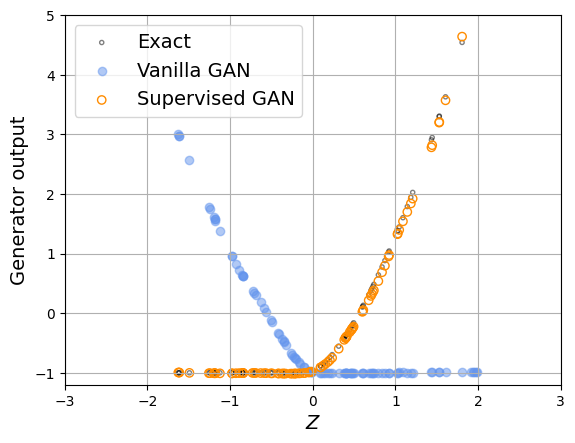

In [29]:
# Create a small dataset for this experiment 
n_plot = 100
Y = SDEDataset()
Y.N = n_plot
Y.N_test = 1 # dummy 
# Set parameters 
Y.params['t'] = 1
Y.params['gamma'] = 0.6
Y.params['kappa'] = 0.1
Y.params['S_bar'] = 0.1
Y.params['S0'] = 0.1

Y.generate_CIR_data()


# Make conditional input tensor for both generators 
C_tensor = make_test_tensor(dict(S0=Y.params['S0'],t=Y.params['t']),Y.N,device=device)
# Tranform the dataset back to the pre-processed form, to compare directly with the generator output 
R = preprocess(Y.exact+1e-20,torch.tensor(X.params['S0'],dtype=torch.float32).view(-1,1),\
               proc_type=proc_type,S_ref=X.params['S_bar'])

# Get input-output pairs 
input_G = torch.cat((Y.Z.to(device),C_tensor),axis=1)
output_vanilla = netG_vanilla(input_G).detach().view(-1).cpu().numpy()
output_supervised = netG(input_G).detach().view(-1).cpu().numpy()

# Make scatter plots 
plt.figure(dpi=100)
plt.scatter(Y.Z.view(-1).cpu().numpy(),R[0:n_plot].view(-1).numpy(),label='Exact',alpha=0.5,marker='.',facecolors='none',edgecolors='k')
plt.scatter(Y.Z.view(-1).cpu().numpy(),output_vanilla[0:n_plot],label='Vanilla GAN',alpha=0.5,color='cornflowerblue')
plt.scatter(Y.Z.view(-1).cpu().numpy(),output_supervised[0:n_plot],label='Supervised GAN',marker='o',alpha=1,facecolors='none',edgecolors='darkorange')

plt.xlabel('$Z$',fontsize=fs)
plt.ylabel('Generator output',fontsize=fs)
plt.legend(fontsize=fs)
plt.grid('on')
plt.xlim([-3,3])
plt.ylim([-1.2,5])



$\Rightarrow$ The input-output maps from both GANs show why the supervised GAN was able to provide a strong approximation: each sample overlaps with the exact samples. The vanilla GAN has found a weak approximation. Note the symmetry, hinting that the vanilla GAN has found a solution approximating $-Z$. 